## Logistic regression con discesa del gradiente

In [ ]:
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [1]:
import pandas as pd
import numpy as np
import scipy.special as sp

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.style.use('fivethirtyeight')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c', 
'#137e6d', '#be0119', '#3b638c', '#af6f09', '#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', 
'#810f7c', '#137e6d', '#be0119', '#3b638c', '#af6f09']

cmap = mcolors.LinearSegmentedColormap.from_list("", ["#82cafc", "#069af3", "#0485d1", colors[0], colors[8]])

Funzione che effettua la normalizzazione del dataset. Modifica la distribuzione dei dati di ogni feature in modo che abbia media 0 e varianza 1, applicando la trasformazione $$x'=\frac{x-\mu}{\sigma}$$ 

In [3]:
def normalizza(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0, ddof=1)
    return (X-mu)/sigma

Funzione di classificazione. Verifica per ogni elemento del dataset da che parte si trova rispetto all'iperpiano di separazione delle due classi i cui parametri sono stati determinati nel corso del training. La verifica è effettuata osservando il segno di $$\theta\cdot\overline x=\theta_0+\sum_{i=1}^d \theta_ix_i$$

In [4]:
def classify(theta, X ):
   y = np.dot(X,theta)
   return np.where(y>0, 1, 0)

Funzione di calcolo e stampa di statistiche

In [5]:
def statistics(theta,X,t):
    # confusion matrix
    y=classify(theta,X)
    confmat = np.zeros((2, 2))
    for i in range(2):
        for j in range(2):
            confmat[i,j] = np.sum(np.where(y==i,1,0)*np.where(t==j,1,0))
    print 'Veri negativi: '+str(int(confmat[0,0]))
    print 'Falsi negativi: '+str(int(confmat[0,1]))
    print 'Falsi positivi: '+str(int(confmat[1,0]))
    print 'Veri positivi: '+str(int(confmat[1,1]))
    print 'Precision insieme 1: '+str(round(confmat[1,1]/(confmat[1,1]+confmat[1,0]),2))
    print 'Recall insieme 1: '+str(round(confmat[1,1]/(confmat[1,1]+confmat[0,1]),2))
    print 'Precision insieme 2: '+str(round(confmat[0,0]/(confmat[0,0]+confmat[0,1]),2))
    print 'Recall insieme 2: '+str(round(confmat[0,0]/(confmat[0,0]+confmat[1,0]),2))
    print 'Accuracy: '+str(round(np.trace(confmat)/n,2))
    return confmat

Funzione che calcola la funzione logistica per tutti i valori di un array, calcolando $$\sigma(x)=\frac{1}{1+e^{\theta\cdot\overline x}}$$

In [6]:
def h(theta, X):
    return sp.expit(np.dot(X, theta))

Funzione gradiente, array delle derivate del costo rispetto a $\theta_0,\ldots,\theta_d$. Risulta $$-\sum (t_i-y_i)x_i$$ diviso per $n$

In [7]:
def gradient(theta, X, t):
    return -np.dot(X.T, (t-h(theta, X))) / len(X)

Funzione costo, definita come il negativo della log verosimiglianza. $$-\sum t_i\log(y_i)-\sum (1-t_i)\log(1-y_i)$$ dove $y_i=\sigma(\theta\cdot\overline x_i)$. Il risultato è diviso per $n$ per evitare valori eccessivamente grandi.

In [8]:
def cost(theta, X, t):
    term1 = np.dot(np.log(h(theta,X)).T,t)
    term2 = np.dot(np.log(1.0 - h(theta,X)).T,1-t)
    return ((-term1 - term2) / len(X))[0]

Leggiamo i dati da un file csv in un dataframe pandas. I dati hanno 3 valori: i primi due corrispondono alle features e sono assegnati alle colonne x1 e x2 del dataframe; il terzo è il valore target, assegnato alla colonna t. Vengono poi creati una matrice X delle features e un vettore target t

In [9]:
# legge i dati in dataframe pandas
data = pd.read_csv("../../data/testSet.txt", delim_whitespace=True, header=None, names=['x1','x2','t'])

# calcola dimensione dei dati
n = len(data)

# calcola dimensionalità delle features
nfeatures = len(data.columns)-1

X = np.array(data[['x1','x2']])
t = np.array(data['t']).reshape(-1,1)

Visualizza il dataset

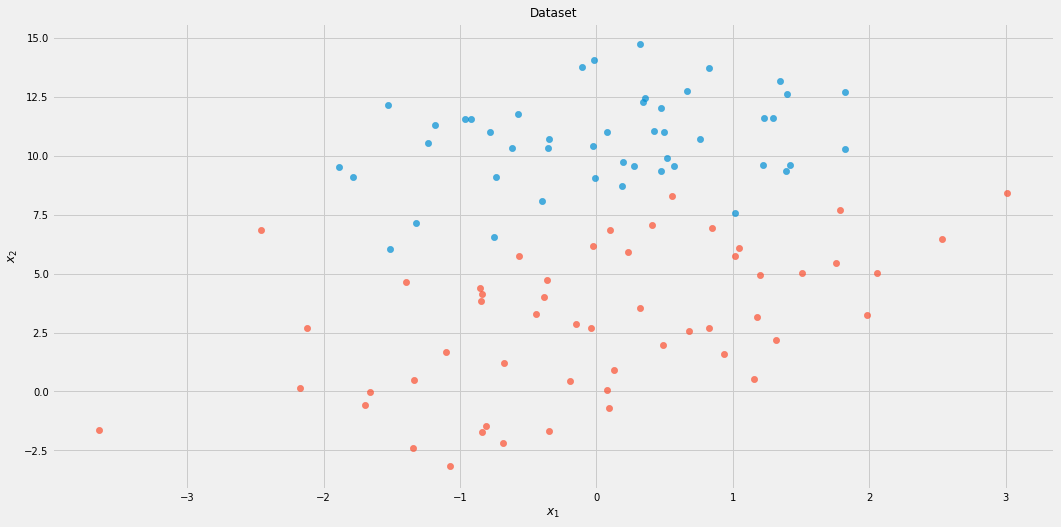

In [11]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
ax.scatter(data[data.t==0].x1, data[data.t==0].x2, s=40, color=colors[0], alpha=.7)
ax.scatter(data[data.t==1].x1, data[data.t==1].x2, s=40, color=colors[1], alpha=.7)
plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Dataset', fontsize=12)
plt.show()

Per applicare il vettore dei coefficienti agli elementi del dataset, introduciamo una colonna unitaria

In [12]:
X = np.column_stack((np.ones(n), X))

Fissa un valore per il parametro $\alpha$ del metodo di discesa del gradiente e per il numero di iterazione del metodo da eseguire

In [13]:
alpha = 0.1
niterations = 10000

Inizializza il vettore dei coefficienti

In [14]:
theta_init = np.zeros(nfeatures+1).reshape(-1,1)

Calcola l'array degli errori per il valore iniziale dei coefficienti

In [15]:
e = h(theta_init,X)-t

Applica la discesa del gradiente, mantenendo in $\theta$ i coefficienti attuali e memorizzando la storia dei valori dei coefficienti e dei relativi costi

In [16]:
theta_history = []
cost_history = []
theta = np.copy(theta_init)
for k in range(niterations):             
        theta = theta - alpha * gradient(theta,X,t)
        theta_history.append(theta)
        cost_history.append(cost(theta, X, t))

Traforma le liste theta_history e cost_history in array

In [17]:
theta_history = np.array(theta_history).reshape(-1,3)
cost_history = np.array(cost_history).reshape(-1,1)

Calcola i valori dei due coefficienti indipendenti

In [18]:
t1=-theta_history[:,1]/theta_history[:,2]
t0=-theta_history[:,0]/theta_history[:,2]

Visualizza serie storica dei valori dei coefficienti indipendenti

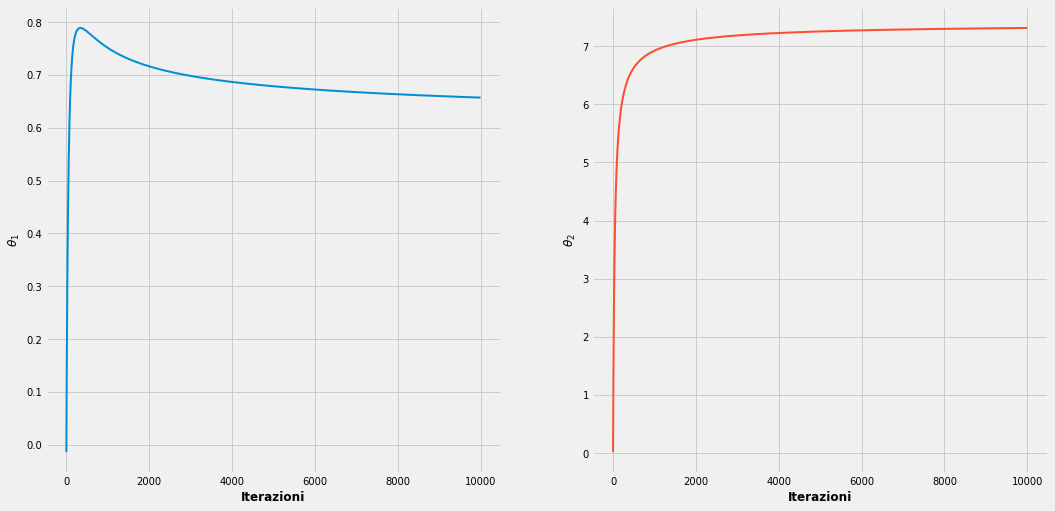

In [24]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
ax.plot(range(niterations), t1, c=colors[0], alpha=1)
plt.xlabel('Iterazioni', fontsize=12)
plt.ylabel(r'$\theta_1$', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax = fig.add_subplot(122)
ax.plot(range(niterations), t0, c=colors[1], alpha=1)
plt.xlabel('Iterazioni', fontsize=12)
plt.ylabel(r'$\theta_2$', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

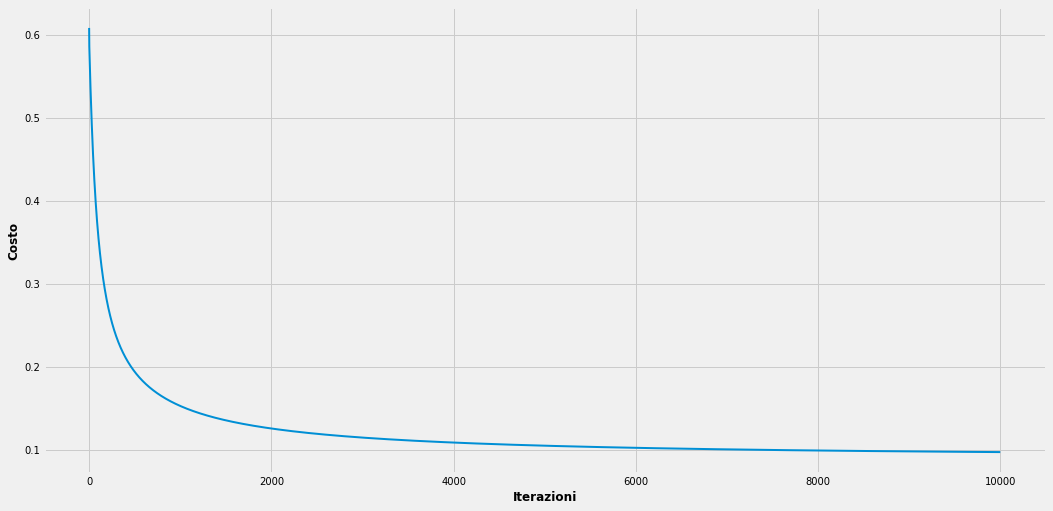

In [25]:
# visualizza andamento coefficienti e costo

fig = plt.figure(figsize=(16,8))
ax = fig.gca()
ax.plot(range(niterations), cost_history, c=colors[0],alpha=1)
plt.xlabel('Iterazioni', fontsize=12)
plt.ylabel('Costo', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


Definiamo la griglia su cui calcolare i valori della logistica

In [26]:
delta1=max(X[:,1])-min(X[:,1])
delta2=max(X[:,2])-min(X[:,2])
min1=min(X[:,1])-delta1/10
max1=max(X[:,1])+delta1/10
min2=min(X[:,2])-delta2/10
max2=max(X[:,2])+delta2/10
u = np.linspace(min1, max1, 100)
v = np.linspace(min2, max2, 100)
u, v = np.meshgrid(u, v)
z=h(theta,np.column_stack((np.ones(u.shape[0]*u.shape[1]), np.c_[u.ravel(), v.ravel()])))
z = z.reshape(u.shape)

Visualizziamo il valore della logistica e l'iperpiano di separazione

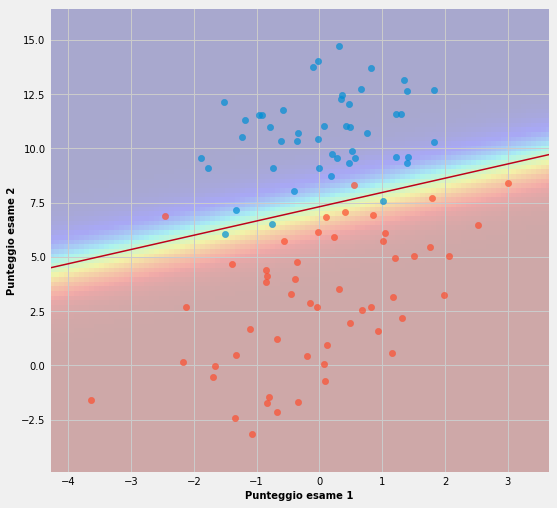

In [27]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
imshow_handle = plt.imshow(z, origin='lower', aspect='auto', extent=(min1, max1, min2, max2), alpha=.3)
ax.scatter(data[data.t==0].x1, data[data.t==0].x2, s=40, color=colors[0], alpha=.7)
ax.scatter(data[data.t==1].x1, data[data.t==1].x2, s=40, color=colors[1], alpha=.7)
plt.contour(u, v, z, [0.5], colors=[colors[7]], linewidths=[1.5])
plt.xlabel('Punteggio esame 1', fontsize=10)
plt.ylabel('Punteggio esame 2', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(min1, max1)
plt.ylim(min2, max2)
plt.show()

Calcola statistiche

In [28]:
cm=statistics(theta,X,t)

Veri negativi: 44
Falsi negativi: 2
Falsi positivi: 3
Veri positivi: 51
Precision insieme 1: 0.94
Recall insieme 1: 0.96
Precision insieme 2: 0.96
Recall insieme 2: 0.94
Accuracy: 0.95


Calcola la curva ROC per diversi valori della soglia

In [29]:
y = h(theta,X)

In [30]:
values = 1000
thresholds = np.linspace(1,0,values+1)

roc = np.zeros((values+1,3))

for i in range(values+1):
    thr = thresholds[i]
    roc[i,0] = thr
    # conta true positive, true negative, false positive e false negative per la soglia attuale
    tp = np.logical_and( y > thr, t==1 ).sum()
    tn = np.logical_and( y <=thr, t==0 ).sum()
    fp = np.logical_and( y > thr, t==0 ).sum()
    fn = np.logical_and( y <=thr, t==1 ).sum()
    # calcola false positive rate e true positive rate per la soglia attuale e li inserisce nell'array
    fpr = fp/float(fp+tn)
    roc[i,1] = fpr
    tpr = tp/float(tp+fn)
    roc[i,2] = tpr

In [31]:
auc = 0.
for i in range(values):
    auc += (roc[i+1,1]-roc[i,1]) * (roc[i+1,2]+roc[i,2])
auc *= 0.5

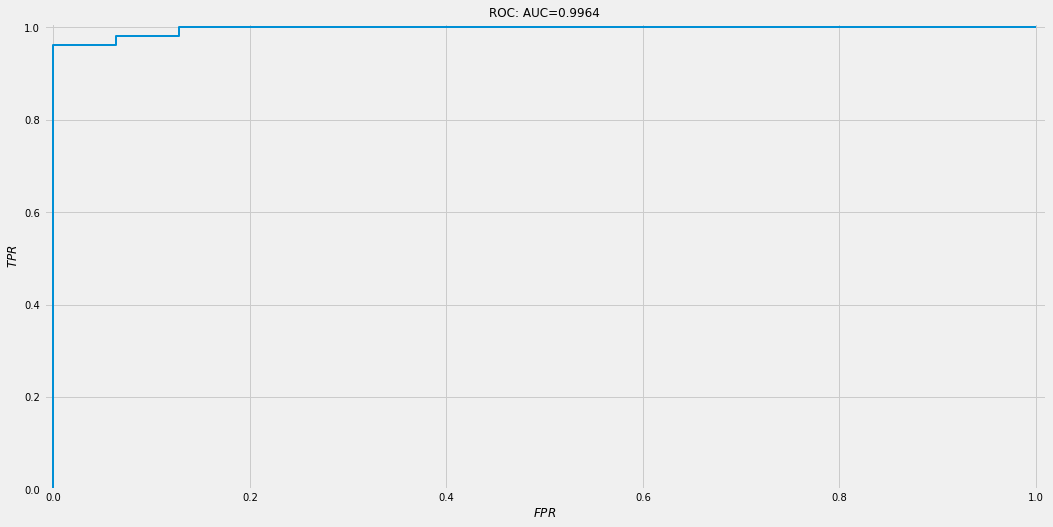

In [32]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
plt.plot(roc[:,1], roc[:,2], color=colors[0],lw=2)
plt.xlim(-0.01,1.01)
plt.ylim(0,1.01)
plt.xlabel('$FPR$', fontsize=12)
plt.ylabel('$TPR$', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('ROC: AUC={0:5.4f}'.format(auc), fontsize=12)
plt.show()

Applicazione del metodo della discesa del gradiente on line

In [33]:
alpha = 0.01
niterations=200
theta = np.zeros(nfeatures+1)

theta_history = []
cost_history = []

# Calcola l'array degli errori e il costo quadratico medio
e = h(theta_init,X)-t

for j in range(niterations):
    for i in range(n):
        e = t[i] - h(theta, X[i])
        theta = theta + alpha * e * X[i]
        theta_history.append(theta)
        cost_history.append(cost(theta, X, t))

theta_history = np.array(theta_history).reshape(-1,3)
cost_history = np.array(cost_history).reshape(-1,1)

In [34]:
cost_history[:20]

array([[0.61196689],
       [0.63376826],
       [0.61111659],
       [0.60007004],
       [0.59807514],
       [0.6083791 ],
       [0.59743959],
       [0.61546164],
       [0.5996937 ],
       [0.59741445],
       [0.60756684],
       [0.59676917],
       [0.59971774],
       [0.59537903],
       [0.6034121 ],
       [0.60720715],
       [0.63971433],
       [0.65735437],
       [0.66019676],
       [0.71105404]])

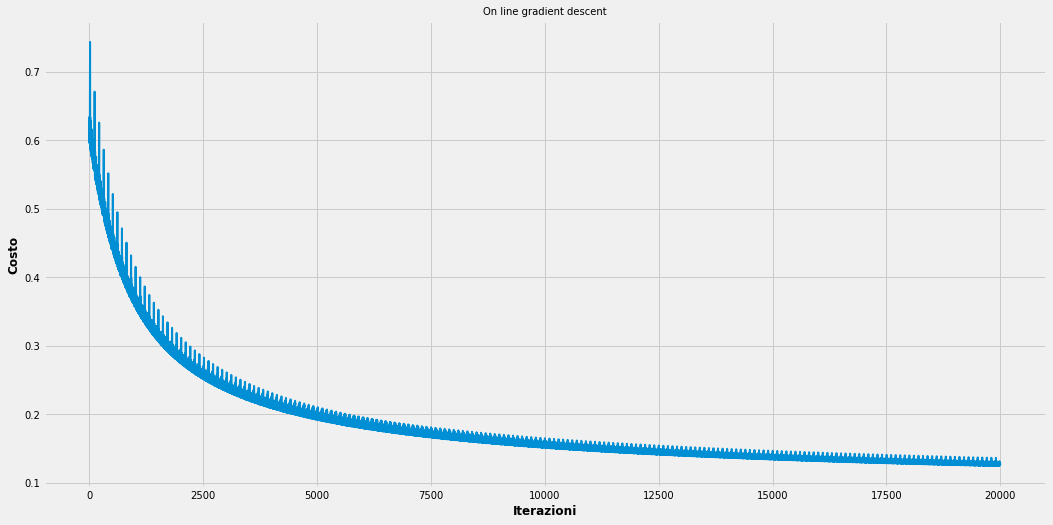

In [35]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
ax.plot(range(niterations*n), cost_history, c=colors[0],alpha=1)
plt.xlabel('Iterazioni', fontsize=12)
plt.ylabel('Costo', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('On line gradient descent')
plt.show()

In [36]:
t1=-theta_history[:,1]/theta_history[:,2]
t0=-theta_history[:,0]/theta_history[:,2]

z=h(theta,np.column_stack((np.ones(u.shape[0]*u.shape[1]), np.c_[u.ravel(), v.ravel()])))
z = z.reshape(u.shape)

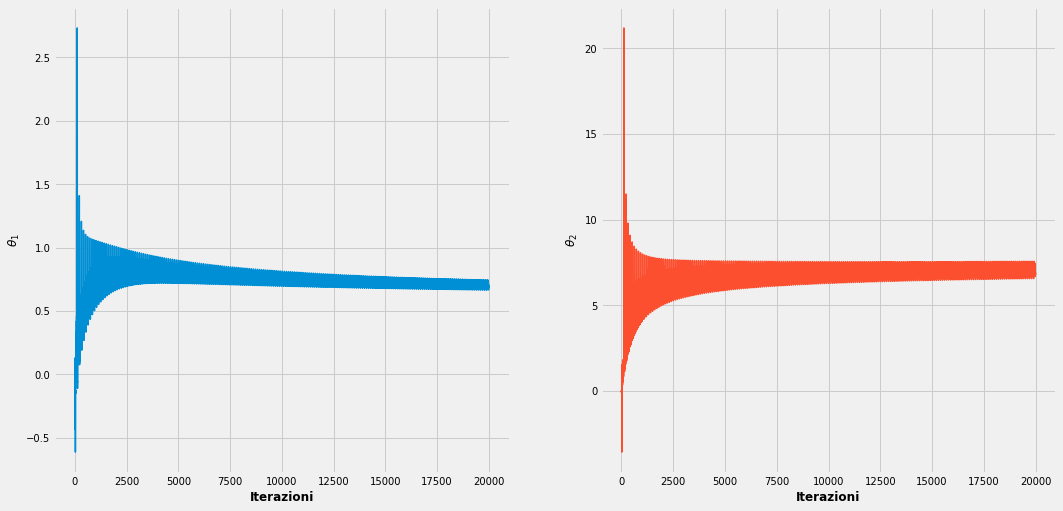

In [37]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
ax = fig.gca()
ax.plot(range(n*niterations), t1, lw=1.5, c=colors[0], alpha=1)
plt.xlabel('Iterazioni', fontsize=12)
plt.ylabel(r'$\theta_1$', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax = fig.add_subplot(122)
ax.plot(range(n*niterations), t0, lw=1.5, c=colors[1], alpha=1)
plt.xlabel('Iterazioni', fontsize=12)
plt.ylabel(r'$\theta_2$', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

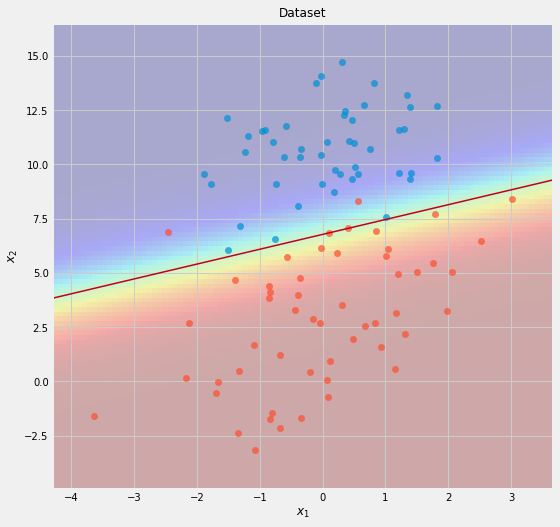

In [39]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
imshow_handle = plt.imshow(z, origin='lower', aspect='auto', extent=(min1, max1, min2, max2), alpha=.3)
ax.scatter(data[data.t==0].x1, data[data.t==0].x2, s=40, c = colors[0], alpha=.7)
ax.scatter(data[data.t==1].x1, data[data.t==1].x2, s=40, c = colors[1], alpha=.7)
plt.contour(u, v, z, [0.5], colors=[colors[7]],linewidths=[1.5])
plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Dataset', fontsize=12)
plt.show()

In [40]:
cm=statistics(theta.reshape(-1,1),X,t)

Veri negativi: 47
Falsi negativi: 3
Falsi positivi: 0
Veri positivi: 50
Precision insieme 1: 1.0
Recall insieme 1: 0.94
Precision insieme 2: 0.94
Recall insieme 2: 1.0
Accuracy: 0.97


Gradiente on line con scelta random dell'elemento da considerare (estrazione senza replacement) e smorzamento del parametro

In [41]:
alpha = 0.01
niterations=200
theta = np.zeros(nfeatures+1)

theta_history = []
cost_history = []

# Calcola l'array degli errori e il costo quadratico medio
e = t-h(theta_init,X)
 
for j in range(niterations):
    dataIndex = range(n)
    for i in range(n):
        alpha = 1/(1.0+j+i)+0.0001    #alpha diminuisce
        r = int(np.random.uniform(0,len(dataIndex)))
        e = t[r] - h(theta, X[r])
        theta = theta + alpha * e * X[r]
        del(dataIndex[r]) 
        theta_history.append(theta)
        cost_history.append(cost(theta, X, t))

theta_history = np.array(theta_history).reshape(-1,3)
cost_history = np.array(cost_history).reshape(-1,1)

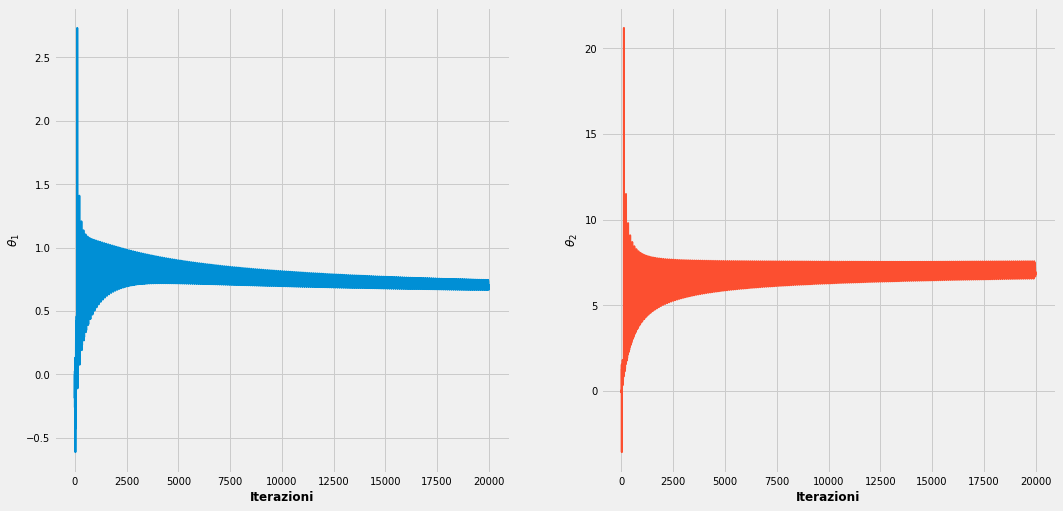

In [42]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
ax = fig.gca()
ax.plot(range(n*niterations), t1, c=colors[0], alpha=1)
plt.xlabel('Iterazioni', fontsize=12)
plt.ylabel(r'$\theta_1$', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax = fig.add_subplot(122)
ax.plot(range(n*niterations), t0, c=colors[1], alpha=1)
plt.xlabel('Iterazioni', fontsize=12)
plt.ylabel(r'$\theta_2$', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

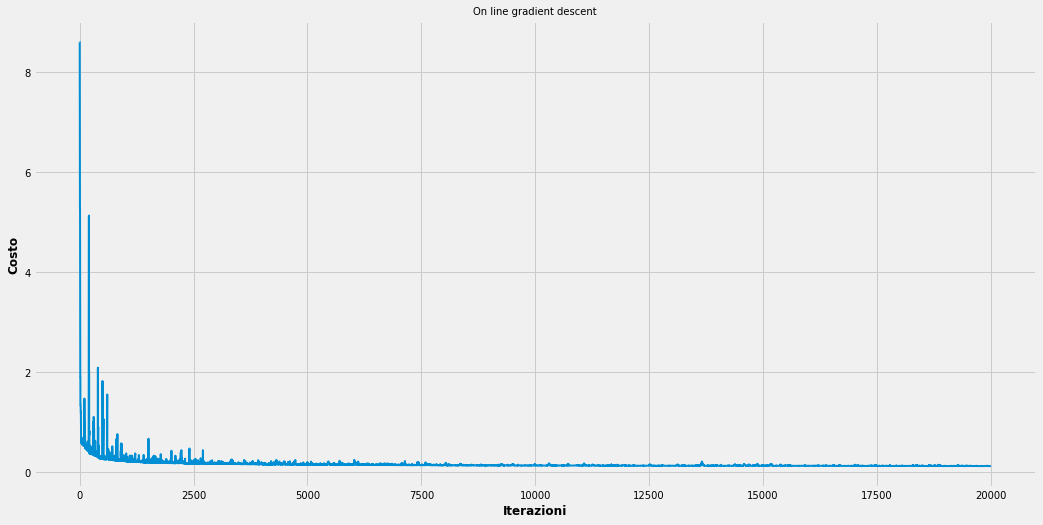

In [43]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
ax.plot(range(niterations*n), cost_history, c=colors[0],alpha=1)
plt.xlabel('Iterazioni', fontsize=12)
plt.ylabel('Costo', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('On line gradient descent')
plt.show()

In [44]:
t1=-theta_history[:,1]/theta_history[:,2]
t0=-theta_history[:,0]/theta_history[:,2]

z=h(theta,np.column_stack((np.ones(u.shape[0]*u.shape[1]), np.c_[u.ravel(), v.ravel()])))
z = z.reshape(u.shape)

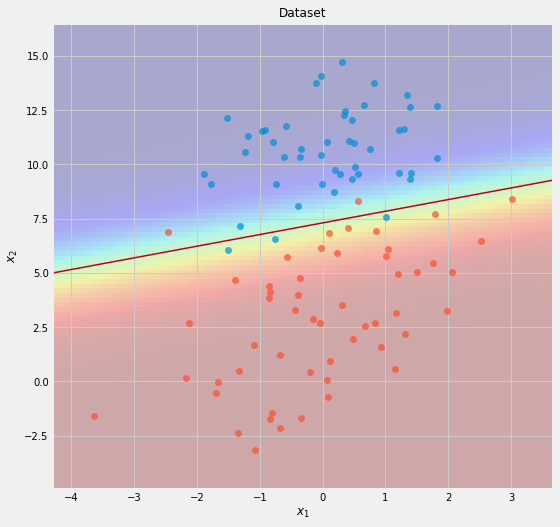

In [45]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
imshow_handle = plt.imshow(z, origin='lower', aspect='auto', extent=(min1, max1, min2, max2), alpha=.3)
ax.scatter(data[data.t==0].x1, data[data.t==0].x2, s=40, c=colors[0], alpha=.7)
ax.scatter(data[data.t==1].x1, data[data.t==1].x2, s=40, c=colors[1], alpha=.7)
plt.contour(u, v, z, [0.5], colors=[colors[7]],linewidths=[1.5])
plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Dataset', fontsize=12)
plt.show()

In [46]:
cm=statistics(theta.reshape(-1,1),X,t)

Veri negativi: 44
Falsi negativi: 2
Falsi positivi: 3
Veri positivi: 51
Precision insieme 1: 0.94
Recall insieme 1: 0.96
Precision insieme 2: 0.96
Recall insieme 2: 0.94
Accuracy: 0.95
